In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("..")

In [3]:
from constrerl.evaluate import (
    eval_submission_6_1_NER,
    eval_submission_6_3_ternary_tag_RE,
    eval_submission_6_4_ternary_mention_RE,
    eval_submission_6_2_binary_tag_RE,
)
from constrerl.erl_schema import convert_to_output, Article
import glob
from pathlib import Path
import json
import pandas as pd
from collections.abc import Callable, Awaitable


In [ ]:
results_dir = "../data/results_dev"
ground_truth_file = "../data/annotations/dev/dev.json"
report_dir = Path("report")
results_dir = Path(results_dir)
ner_result_dir = Path("../data/results_ner_dev")
ground_truth_file = Path(ground_truth_file)
lbl_xtra = ":more"


top_results = 0

k_limits = [None]

with open(ground_truth_file) as f:
    ground_truth = json.load(f)

In [124]:
eval_results: list[dict] = []

import re


def scoring_to_dict(
    predictions: dict, eval_f: Callable[[dict, dict], tuple[float]], gt=ground_truth
) -> dict:
    precision, recall, f1, micro_precision, micro_recall, micro_f1 = eval_f(
        predictions, gt
    )
    return {
        "$P$": precision,
        "$R$": recall,
        "$F_1$": f1,
        "$P_{micro}$": micro_precision,
        "$R_{micro}$": micro_recall,
        "$F_{1,micro}$": micro_f1,
    }


def scoring_to_df(
    eval_f: Callable[[str | Path, dict], tuple[float]],
    key: str,
    res_dir=results_dir,
    k_limits_set=None,
    cap_gt=False,
) -> pd.DataFrame:
    eval_results: list[dict] = []
    merge_mode = "merge" in str(res_dir)
    further_mode = not (("old" in str(res_dir)) or ("merge" in str(res_dir)))
    print(f"Further mode: {further_mode}")
    files = res_dir.glob("*.json")
    if not res_dir.is_dir():
        files = [res_dir]
    for result_file in files:
        set_mode = False
        result_file = Path(result_file)
        try:
            with open(result_file, "r", encoding="utf-8") as file:
                predictions: dict = json.load(file)
        except OSError:
            raise OSError(f"Error in opening the specified json file: {result_file}")

        if k_limits_set is None or len(k_limits_set) == 0:
            k_list = [None]
        else:
            k_list = k_limits_set
        for k in k_list:
            predictions_limited = predictions.copy()
            predictions_limited = {
                id: {key: predictions_limited[id][key][:k]}
                for id in predictions_limited.keys()
            }
            k_gt: dict = ground_truth.copy()
            if cap_gt:
                k_gt = {id: {key: k_gt[id][key][:k]} for id in k_gt.keys()}
            if "union" in result_file.name or "intersection" in result_file.name:
                set_mode = True
            set_op = "$\cup$" if "union" in result_file.name else "$\cap$"
            eval_result = scoring_to_dict(predictions_limited, eval_f, gt=k_gt)
            model_name = result_file.name.rstrip(".json")
            if set_mode:
                model_name = model_name.rstrip("_intersection").rstrip("_union")
            model_name = (
                " ".join(model_name.rstrip(".json").split("-")[:2])
                if "openai" not in model_name
                else " ".join(model_name.rstrip(".json").split("-")[:3])
            )
            # capitalize the first letter of the name
            model_name = " ".join(
                [
                    word.capitalize() if i == 0 else word
                    for i, word in enumerate(model_name.split(" "))
                ]
            )
            model_name = re.sub(r"(\d)b", "\\1B", model_name)
            splits = model_name.split(" ")
            if len(splits) > 2:
                model_name = splits[0] + " " + "-".join(splits[1:])
            low_tokens = "low-tokens" in result_file.name
            entity_labels = "entity-labels" in result_file.name
            result_dict = {
                "Model": model_name,
                "RAG": "\checkmark" if "rag" in result_file.name else "$\\times$",
                "Reorder": "\checkmark"
                if "reorder" in result_file.name
                else "$\\times$",
                # "Low Tokens": "\checkmark"
                # if "low-tokens" in result_file.name
                # else "$\\times$",
                # "Entity Labels": "\checkmark"
                # if "entity-labels" in result_file.name
                # else "$\\times$",
            }
            if further_mode:
                result_dict["LoRA+"] = (
                    "\checkmark" if "long" in result_file.name else "$\\times$"
                )
                result_dict["Low $t$"] = "\checkmark" if low_tokens else "$\\times$"
                result_dict["Entities"] = "\checkmark" if entity_labels else "$\\times$"
                if k_limits_set is not None and len(k_limits_set) > 0:
                    result_dict["$k$"] = k if k is not None else "$\\times$"
            else:
                result_dict["LoRA"] = (
                    "\checkmark" if "lora" in result_file.name else "$\\times$"
                )
            if set_mode:
                result_dict["Set"] = set_op
            result_dict.update(eval_result)
            # result_dict.update({f"6_2_2_{k}": v for k, v in ternary_tag_score.items()})
            # result_dict.update({f"6_2_3_{k}": v for k, v in ternary_mention_score.items()})
            eval_results.append(result_dict)
    eval_df = pd.DataFrame(eval_results)
    if further_mode and "$k$" not in eval_df.columns:
        eval_df = eval_df[
            (eval_df["Low $t$"] == "\checkmark")
            | (eval_df["Entities"] == "\checkmark")
            | (eval_df["LoRA+"] == "\checkmark")
        ]
    if merge_mode:
        eval_df = eval_df[eval_df["Model"].str.contains("Hermes 3B")]
    valid_cols = [
        c
        for c in [
            "Set",
            "Model",
            "RAG",
            "LoRA",
            "LoRA+",
            "Reorder",
            "Low $t$",
            "Entities",
            "$k$",
        ]
        if c in eval_df.columns
    ]
    eval_df.set_index(valid_cols, inplace=True)
    eval_df = eval_df.sort_index()
    # if "$F_{1,micro}$" in eval_df.columns:
    #     eval_df = eval_df.sort_values("$F_{1,micro}$")
    return eval_df


task_6_1_1_df = scoring_to_df(
    eval_submission_6_1_NER, "entities", res_dir=ner_result_dir
)
task_6_2_1_df = scoring_to_df(
    eval_submission_6_2_binary_tag_RE, "binary_tag_based_relations"
)
task_6_2_2_df = scoring_to_df(
    eval_submission_6_3_ternary_tag_RE, "ternary_tag_based_relations"
)
task_6_2_3_df = scoring_to_df(
    eval_submission_6_4_ternary_mention_RE, "ternary_mention_based_relations"
)

Further mode: True
=== Removed 458 duplicated entities from predictions ===
=== Removed 111 overlapping entities ===
=== Removed 335 duplicated entities from predictions ===
=== Removed 86 overlapping entities ===
=== Removed 89 duplicated entities from predictions ===
=== Removed 35 overlapping entities ===
=== Removed 458 duplicated entities from predictions ===
=== Removed 111 overlapping entities ===
=== Removed 399 duplicated entities from predictions ===
=== Removed 61 overlapping entities ===
=== Removed 231 duplicated entities from predictions ===
=== Removed 82 overlapping entities ===
=== Removed 101 duplicated entities from predictions ===
=== Removed 48 overlapping entities ===
=== Removed 85 duplicated entities from predictions ===
=== Removed 64 overlapping entities ===
=== Removed 231 duplicated entities from predictions ===
=== Removed 82 overlapping entities ===
=== Removed 92 duplicated entities from predictions ===
=== Removed 61 overlapping entities ===
=== Removed 

<>:60: SyntaxWarning: invalid escape sequence '\c'
<>:60: SyntaxWarning: invalid escape sequence '\c'
<>:85: SyntaxWarning: invalid escape sequence '\c'
<>:86: SyntaxWarning: invalid escape sequence '\c'
<>:98: SyntaxWarning: invalid escape sequence '\c'
<>:100: SyntaxWarning: invalid escape sequence '\c'
<>:101: SyntaxWarning: invalid escape sequence '\c'
<>:106: SyntaxWarning: invalid escape sequence '\c'
<>:117: SyntaxWarning: invalid escape sequence '\c'
<>:118: SyntaxWarning: invalid escape sequence '\c'
<>:119: SyntaxWarning: invalid escape sequence '\c'
<>:60: SyntaxWarning: invalid escape sequence '\c'
<>:60: SyntaxWarning: invalid escape sequence '\c'
<>:85: SyntaxWarning: invalid escape sequence '\c'
<>:86: SyntaxWarning: invalid escape sequence '\c'
<>:98: SyntaxWarning: invalid escape sequence '\c'
<>:100: SyntaxWarning: invalid escape sequence '\c'
<>:101: SyntaxWarning: invalid escape sequence '\c'
<>:106: SyntaxWarning: invalid escape sequence '\c'
<>:117: SyntaxWarning:

In [125]:
task_6_1_1_df[top_results:].to_latex(
    report_dir / "task_6_1_1.tex",
    float_format="%.2f",
    caption="Dev Set Result for Task 6.1.1 (NER) for various models and approaches.",
    label=f"tab:task:6_1_1{lbl_xtra}",
)
task_6_1_1_df

$P$  \
Model     RAG        LoRA+    Reorder    Low $t$    Entities               
Hermes 3B $\times$   $\times$ $\times$   $\times$   \checkmark  0.048768   
                                         \checkmark $\times$    0.015713   
                                                    \checkmark  0.045376   
                              \checkmark $\times$   \checkmark  0.048768   
                                         \checkmark \checkmark  0.045376   
          \checkmark $\times$ $\times$   $\times$   \checkmark  0.212756   
                                         \checkmark $\times$    0.318396   
                                                    \checkmark  0.252185   
                              \checkmark $\times$   \checkmark  0.212756   
                                         \checkmark \checkmark  0.252185   

                                                                     $R$  \
Model     RAG        LoRA+    Reorder    Low $t$    Entities               
Hermes 3B $\times$   $\times$ $\times$   $\times$   \checkmark  0.018770   
                                         \checkmark $\times$    0.017106   
                                                    \checkmark  0.016660   
                              \checkmark $\times$   \checkmark  0.018770   
                                         \checkmark \checkmark  0.016660   
          \checkmark $\times$ $\times$   $\times$   \checkmark  0.081851   
                                         \checkmark $\times$    0.066426   
                                                    \checkmark  0.054985   
                              \checkmark $\times$   \checkmark  0.081851   
                                         \checkmark \checkmark  0.054985   

                                                                   $F_1$  \
Model     RAG        LoRA+    Reorder    Low $t$    Entities               
Hermes 3B $\times$   $\times$ $\times$   $\times$   \checkmark  0.025532   
                                         \checkmark $\times$    0.013724   
                                                    \checkmark  0.022781   
                              \checkmark $\times$   \checkmark  0.025532   
                                         \checkmark \checkmark  0.022781   
          \checkmark $\times$ $\times$   $\times$   \checkmark  0.112518   
                                         \checkmark $\times$    0.099484   
                                                    \checkmark  0.083981   
                              \checkmark $\times$   \checkmark  0.112518   
                                         \checkmark \checkmark  0.083981   

                                                                $P_{micro}$  \
Model     RAG        LoRA+    Reorder    Low $t$    Entities                  
Hermes 3B $\times$   $\times$ $\times$   $\times$   \checkmark     0.055046   
                                         \checkmark $\times$       0.037415   
                                                    \checkmark     0.057221   
                              \checkmark $\times$   \checkmark     0.055046   
                                         \checkmark \checkmark     0.057221   
          \checkmark $\times$ $\times$   $\times$   \checkmark     0.250000   
                                         \checkmark $\times$       0.292500   
                                                    \checkmark     0.308970   
                              \checkmark $\times$   \checkmark     0.250000   
                                         \checkmark \checkmark     0.308970   

                                                                $R_{micro}$  \
Model     RAG        LoRA+    Reorder    Low $t$    Entities                  
Hermes 3B $\times$   $\times$ $\times$   $\times$   \checkmark     0.021486   
                                         \checkmark $\times$       0.009848   
                                                    \checkmark   

In [126]:
task_6_2_1_df[top_results:].to_latex(
    report_dir / "task_6_2_1.tex",
    float_format="%.2f",
    caption="Dev Set Result for Task 6.2.1 for various models and approaches.",
    label=f"tab:task:6_2_1{lbl_xtra}",
)
task_6_2_1_df

$P$  \
Model     RAG        LoRA+      Reorder    Low $t$    Entities               
Hermes 3B $\times$   $\times$   $\times$   $\times$   \checkmark  0.064286   
                                           \checkmark $\times$    0.044444   
                                                      \checkmark  0.066049   
                                \checkmark $\times$   \checkmark  0.064286   
                                           \checkmark \checkmark  0.066049   
                     \checkmark $\times$   $\times$   $\times$    0.205929   
                                           \checkmark $\times$    0.220328   
                                                      \checkmark  0.167507   
                                \checkmark \checkmark \checkmark  0.167507   
          \checkmark $\times$   $\times$   \checkmark $\times$    0.240278   
                                                      \checkmark  0.158418   
                                \checkmark \checkmark \checkmark  0.158418   
                     \checkmark $\times$   $\times$   $\times$    0.197019   
                                           \checkmark $\times$    0.181251   
                                                      \checkmark  0.170300   
                                \checkmark \checkmark \checkmark  0.170300   

                                                                       $R$  \
Model     RAG        LoRA+      Reorder    Low $t$    Entities               
Hermes 3B $\times$   $\times$   $\times$   $\times$   \checkmark  0.086162   
                                           \checkmark $\times$    0.010582   
                                                      \checkmark  0.069638   
                                \checkmark $\times$   \checkmark  0.086162   
                                           \checkmark \checkmark  0.069638   
                     \checkmark $\times$   $\times$   $\times$    0.118854   
                                           \checkmark $\times$    0.115777   
                                                      \checkmark  0.095978   
                                \checkmark \checkmark \checkmark  0.095978   
          \checkmark $\times$   $\times$   \checkmark $\times$    0.091983   
                                                      \checkmark  0.072784   
                                \checkmark \checkmark \checkmark  0.072784   
                     \checkmark $\times$   $\times$   $\times$    0.115663   
                                           \checkmark $\times$    0.096157   
                                                      \checkmark  0.068337   
                                \checkmark \checkmark \checkmark  0.068337   

                                                                     $F_1$  \
Model     RAG        LoRA+      Reorder    Low $t$    Entities               
Hermes 3B $\times$   $\times$   $\times$   $\times$   \checkmark  0.057367   
                                           \checkmark $\times$    0.016667   
                                                      \checkmark  0.047191   
                                \checkmark $\times$   \checkmark  0.057367   
                                           \checkmark \checkmark  0.047191   
                     \checkmark $\times$   $\times$   $\times$    0.141570   
                                           \checkmark $\times$    0.139703   
                                                      \checkmark  0.112034   
                                \checkmark \checkmark \checkmark  0.112034   
          \checkmark $\times$   $\times$   \checkmark $\times$    0.124187   
                                                      \checkmark  0.088042   
                                \checkmark \checkmark \checkmark  0.088042   
                     \checkmark $\times$   $\times$   $\times$    0.140872   
                                           \checkmark $\times$    0.120045   
             

/tmp/ipykernel_923333/3735139236.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(k_s)


Further mode: True
=== Removed 20 duplicated binary tag-based relations from predictions ===
=== Removed 43 duplicated binary tag-based relations from predictions ===
=== Removed 69 duplicated binary tag-based relations from predictions ===
=== Removed 96 duplicated binary tag-based relations from predictions ===
=== Removed 124 duplicated binary tag-based relations from predictions ===
=== Removed 153 duplicated binary tag-based relations from predictions ===
=== Removed 182 duplicated binary tag-based relations from predictions ===
=== Removed 208 duplicated binary tag-based relations from predictions ===
=== Removed 236 duplicated binary tag-based relations from predictions ===
=== Removed 263 duplicated binary tag-based relations from predictions ===
=== Removed 287 duplicated binary tag-based relations from predictions ===
=== Removed 312 duplicated binary tag-based relations from predictions ===
=== Removed 334 duplicated binary tag-based relations from predictions ===
=== Remove

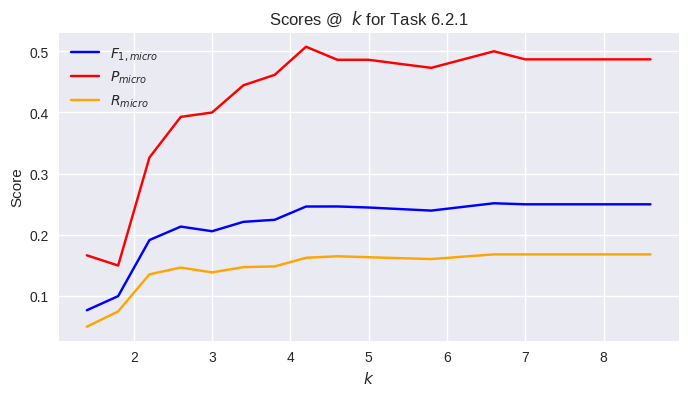

In [127]:
import matplotlib.pyplot as plt
import numpy as np
import tikzplotlib
import re

# style to sbn
plt.style.use("seaborn-v0_8")


def tikzplotlib_fix_ncols(obj):
    """
    workaround for matplotlib 3.6 renamed legend's _ncol to _ncols, which breaks tikzplotlib
    """
    if hasattr(obj, "_ncols"):
        obj._ncol = obj._ncols
    for child in obj.get_children():
        tikzplotlib_fix_ncols(child)


k = list(range(1, 20))


task_6_2_1_df_f1k = scoring_to_df(
    eval_submission_6_2_binary_tag_RE,
    "binary_tag_based_relations",
    k_limits_set=k,
    cap_gt=True,
    res_dir=results_dir / "hermes-3b-rag.json",
)
k_s=task_6_2_1_df_f1k.reset_index()['$k$'].to_numpy()
f1k=task_6_2_1_df_f1k["$F_{1,micro}$"]
p1k=task_6_2_1_df_f1k["$P_{micro}$"]
r1k=task_6_2_1_df_f1k["$R_{micro}$"]

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
ax.plot(k_s, f1k, label="$F_{1,micro}$", color="blue")
ax.plot(k_s, p1k, label="$P_{micro}$", color="red")
ax.plot(k_s, r1k, label="$R_{micro}$", color="orange")
ax.set_ylabel("Score")
ax.set_xlabel("$k$")
ax.set_title("Scores @  $k$ for Task 6.2.1")
ax.legend()
ax.set_xticklabels(k_s)
tikzplotlib_fix_ncols(fig)
tikzplotlib.save(
    "f1_at_k_rerun.tex",
    figure=fig,
    axis_width="0.8\\linewidth",
    axis_height="0.4\\linewidth",
    # extra_axis_parameters={
    #     "legend style": r"legend pos=outer north east",
    #     "legend columns": 1,
    #     "legend cell align": "left",
    #     "legend to name": "loss_legend",
    #     "legend entries": ["loss"],
    # },
)

In [128]:
task_6_2_1_df_f1k.reset_index()['$k$']

0      1
1      2
2      3
3      4
4      5
5      6
6      7
7      8
8      9
9     10
10    11
11    12
12    13
13    14
14    15
15    16
16    17
17    18
18    19
Name: $k$, dtype: int64

In [129]:
task_6_2_2_df[top_results:].to_latex(
    report_dir / "task_6_2_2.tex",
    float_format="%.2f",
    caption="Further Dev Set Result for Task 6.2.2 for various models and approaches.",
    label=f"tab:task:6_2_2{lbl_xtra}",
)
task_6_2_2_df

$P$  \
Model     RAG        LoRA+      Reorder    Low $t$    Entities               
Hermes 3B $\times$   $\times$   $\times$   $\times$   \checkmark  0.073313   
                                           \checkmark $\times$    0.041667   
                                                      \checkmark  0.074074   
                                \checkmark $\times$   \checkmark  0.073313   
                                           \checkmark \checkmark  0.074074   
                     \checkmark $\times$   $\times$   $\times$    0.207100   
                                           \checkmark $\times$    0.220312   
                                                      \checkmark  0.174195   
                                \checkmark \checkmark \checkmark  0.174195   
          \checkmark $\times$   $\times$   \checkmark $\times$    0.214844   
                                                      \checkmark  0.148516   
                                \checkmark \checkmark \checkmark  0.148516   
                     \checkmark $\times$   $\times$   $\times$    0.200578   
                                           \checkmark $\times$    0.189020   
                                                      \checkmark  0.170073   
                                \checkmark \checkmark \checkmark  0.170073   

                                                                       $R$  \
Model     RAG        LoRA+      Reorder    Low $t$    Entities               
Hermes 3B $\times$   $\times$   $\times$   $\times$   \checkmark  0.084183   
                                           \checkmark $\times$    0.009921   
                                                      \checkmark  0.067895   
                                \checkmark $\times$   \checkmark  0.084183   
                                           \checkmark \checkmark  0.067895   
                     \checkmark $\times$   $\times$   $\times$    0.116024   
                                           \checkmark $\times$    0.112845   
                                                      \checkmark  0.094874   
                                \checkmark \checkmark \checkmark  0.094874   
          \checkmark $\times$   $\times$   \checkmark $\times$    0.082479   
                                                      \checkmark  0.069416   
                                \checkmark \checkmark \checkmark  0.069416   
                     \checkmark $\times$   $\times$   $\times$    0.114636   
                                           \checkmark $\times$    0.096054   
                                                      \checkmark  0.069026   
                                \checkmark \checkmark \checkmark  0.069026   

                                                                     $F_1$  \
Model     RAG        LoRA+      Reorder    Low $t$    Entities               
Hermes 3B $\times$   $\times$   $\times$   $\times$   \checkmark  0.057211   
                                           \checkmark $\times$    0.015625   
                                                      \checkmark  0.046027   
                                \checkmark $\times$   \checkmark  0.057211   
                                           \checkmark \checkmark  0.046027   
                     \checkmark $\times$   $\times$   $\times$    0.138154   
                                           \checkmark $\times$    0.136200   
                                                      \checkmark  0.110907   
                                \checkmark \checkmark \checkmark  0.110907   
          \checkmark $\times$   $\times$   \checkmark $\times$    0.112799   
                                                      \checkmark  0.084230   
                                \checkmark \checkmark \checkmark  0.084230   
                     \checkmark $\times$   $\times$   $\times$    0.139833   
                                           \checkmark $\times$    0.120384   
             

In [130]:
task_6_2_3_df[top_results:].to_latex(
    report_dir / "task_6_2_3.tex",
    float_format="%.2f",
    caption="Dev Set Result for Task 6.2.3 for various models and approaches.",
    label=f"tab:task:6_2_3{lbl_xtra}",
)
task_6_2_3_df

$P$  \
Model     RAG        LoRA+      Reorder    Low $t$    Entities               
Hermes 3B $\times$   $\times$   $\times$   $\times$   \checkmark  0.000631   
                                           \checkmark $\times$    0.000000   
                                                      \checkmark  0.001736   
                                \checkmark $\times$   \checkmark  0.000631   
                                           \checkmark \checkmark  0.001736   
                     \checkmark $\times$   $\times$   $\times$    0.058572   
                                           \checkmark $\times$    0.079115   
                                                      \checkmark  0.060072   
                                \checkmark \checkmark \checkmark  0.060072   
          \checkmark $\times$   $\times$   \checkmark $\times$    0.028837   
                                                      \checkmark  0.031675   
                                \checkmark \checkmark \checkmark  0.031675   
                     \checkmark $\times$   $\times$   $\times$    0.075110   
                                           \checkmark $\times$    0.057490   
                                                      \checkmark  0.079367   
                                \checkmark \checkmark \checkmark  0.079367   

                                                                       $R$  \
Model     RAG        LoRA+      Reorder    Low $t$    Entities               
Hermes 3B $\times$   $\times$   $\times$   $\times$   \checkmark  0.003472   
                                           \checkmark $\times$    0.000000   
                                                      \checkmark  0.003472   
                                \checkmark $\times$   \checkmark  0.003472   
                                           \checkmark \checkmark  0.003472   
                     \checkmark $\times$   $\times$   $\times$    0.032772   
                                           \checkmark $\times$    0.031797   
                                                      \checkmark  0.027889   
                                \checkmark \checkmark \checkmark  0.027889   
          \checkmark $\times$   $\times$   \checkmark $\times$    0.008060   
                                                      \checkmark  0.011175   
                                \checkmark \checkmark \checkmark  0.011175   
                     \checkmark $\times$   $\times$   $\times$    0.034066   
                                           \checkmark $\times$    0.025120   
                                                      \checkmark  0.025123   
                                \checkmark \checkmark \checkmark  0.025123   

                                                                     $F_1$  \
Model     RAG        LoRA+      Reorder    Low $t$    Entities               
Hermes 3B $\times$   $\times$   $\times$   $\times$   \checkmark  0.001068   
                                           \checkmark $\times$    0.000000   
                                                      \checkmark  0.002315   
                                \checkmark $\times$   \checkmark  0.001068   
                                           \checkmark \checkmark  0.002315   
                     \checkmark $\times$   $\times$   $\times$    0.038215   
                                           \checkmark $\times$    0.043284   
                                                      \checkmark  0.035630   
                                \checkmark \checkmark \checkmark  0.035630   
          \checkmark $\times$   $\times$   \checkmark $\times$    0.010926   
                                                      \checkmark  0.015035   
                                \checkmark \checkmark \checkmark  0.015035   
                     \checkmark $\times$   $\times$   $\times$    0.043660   
                                           \checkmark $\times$    0.033774   
             